In [30]:
import torch
from torch import nn
from d2l import torch as d2l

In [31]:
# 定义卷积的操作
# 定义二维相关操作
def corr2d(X,K): # K是kernel  X是输入矩阵
    h,w = K.shape
    Y = torch.zeros((X.shape[0]-h+1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h,j:j+w]*K).sum()   # 输入区域和核点积求和
    return Y

In [32]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

In [33]:
# 实现一个卷积层，有核矩阵和偏移量的层
class Conv2D(nn.Module):    # 二维的
    def __init__(self,kernel_size): # kernel_size 可以是3*3或者2*3任意
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self,x):
        return corr2d(x,self.weight)+self.bias

In [34]:
X = torch.ones((6,8))
X[:,2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [35]:
# 使用卷积层来检测图像的边缘
K = torch.tensor([[1.0,-1.0]])  # 两个元素没变的话就是0，不然为1或者-1
Y = corr2d(X,K)
print(Y) # 检测出的边缘结果
# 这个核的缺点是只能检测垂直边缘
corr2d(X.t(),K)

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])


tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [36]:
# 现在构造的卷积层核是随机的，我们想要学习刚刚自己定义的K去做边缘检测
# 使用nn的卷积层，不用自己定义的，这里输入和输出通道都是1
conv2d = nn.Conv2d(1,1,kernel_size=(1,2),bias=False) 

# 这个二维卷积层使用四维输入和输出格式（批量大小、通道、高度、宽度），
# 其中批量大小和通道数都为1
X = X.reshape((1,1,6,8))    # X原来是6行8列，现在增加两个维度
Y = Y.reshape((1,1,6,7))
lr = 3e-2
for i in range(10):
    Y_hat = conv2d(X)  # 卷积结果
    l = (Y_hat-Y)**2   # 卷积结果和真实的边缘识别结果做差平方
    conv2d.zero_grad() # 清理梯度
    l.sum().backward()
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    if(i+1)%2 == 0:
        print(f'batch {i+1},loss {l.sum():.3f}')

batch 2,loss 9.733
batch 4,loss 3.157
batch 6,loss 1.154
batch 8,loss 0.449
batch 10,loss 0.180


In [37]:
conv2d.weight.data


tensor([[[[ 1.0339, -0.9469]]]])

----

填充和步幅

In [38]:
def comp_conv2d(conv2d,X):
    X = X.reshape((1,1)+X.shape) # 加入通道批次
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

# 核大小为3*3
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1) #上下左右都填充一行
X = torch.rand(size=(8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

In [39]:
conv2d = nn.Conv2d(1,1,kernel_size=(5,3),padding=(2,1)) # padding中上下填充都为2，左右都为1
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

In [40]:
conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1,stride=2) # 步幅为2，往下核往右都是2
comp_conv2d(conv2d,X).shape

torch.Size([4, 4])

In [41]:
conv2d = nn.Conv2d(1, 1, kernel_size=(3, 5), padding=(0, 1), stride=(3, 4))
comp_conv2d(conv2d, X).shape

torch.Size([2, 2])

---

多输入和多输出通道

In [42]:
# 多输入通道
def corr2d_multi_in(X,K):  # 多输入和多维核
    return sum(d2l.corr2d(x,k) for x,k in zip(X,K))

# 两个输入通道
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
# 两个卷积核 所以K是三维
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K) # 得到一个输出通道

tensor([[ 56.,  72.],
        [104., 120.]])

In [43]:
# 多输出通道
def corr2d_multi_in_out(X,K): # X还是多个输入，K则是多个三维卷积核
    # 迭代“K”的第0个维度，每次都对输入“X”执行互相关运算。
    # 最后将所有结果都叠加在一起
    return torch.stack([corr2d_multi_in(X,k) for k in K],0)

# 构造多个三维卷积核
K = torch.stack((K,K+1,K+2),0) #从第0个维度将三个二维卷积核拼接


In [44]:
print(K[0].shape)
print(X.shape)
corr2d_multi_in_out(X,K)

torch.Size([2, 2, 2])
torch.Size([2, 3, 3])


tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

In [45]:
# 多个1*1的卷积核，只用于合并多个输入通道输出多个通道
def corr2d_multi_in_out_1x1(X,K):
    c_i,h,w = X.shape    # 输入通道个数，输入高和宽
    c_o = K.shape[0]     # 输出通道个数 
    X = X.reshape((c_i,h*w)) # 拉成2维的
    K = K.reshape((c_o,c_i))
    # 矩阵相乘
    Y = torch.matmul(K,X)
    return Y.reshape((c_o,h,w))

In [46]:
X = torch.normal(0, 1, (3, 3, 3)) # 生成正态的，0-1，形状为3，3，3的矩阵
K = torch.normal(0, 1, (2, 3, 1, 1)) # 输出通道为2

Y1 = corr2d_multi_in_out_1x1(X, K)  # 输出为2通道的三维结果，4d的tensor
Y2 = corr2d_multi_in_out(X, K)      # 同上
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

---- 
汇聚

In [47]:
# 二维汇聚函数

def pool2d(X,pool_size,mode='max'):  # pool_size 最大化的范围
    p_h,p_w = pool_size            
    # 生成的结果大小
    Y = torch.zeros((X.shape[0]-p_h+1,X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                # 两种策略，最大值和平均值
                Y[i,j] = X[i:i+p_h,j:j+p_w].max()
            elif mode == 'avg':
                Y[i,j] = X[i:i+p_h,j:j+p_w].mean()
    return Y

In [48]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2),'avg')

tensor([[2., 3.],
        [5., 6.]])

In [49]:
# 填充和步幅
X = torch.arange(16,dtype=torch.float32).reshape((1,1,4,4))
print(X)
# 调用pytorch的默认汇聚函数
pool2d = nn.MaxPool2d(3) # 3*3的汇聚窗口，默认步幅也是3*3
pool2d(X)

# 手动设定padding和stride
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])


tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [50]:
# 多通道汇聚，作用在每个输入通道，不同于卷积，不会聚合多通道输出单通道
X = torch.cat((X,X+1),1)
print(X)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])


In [53]:
print(X.shape)
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

torch.Size([1, 2, 4, 4])


tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

----------
卷积网络

In [54]:
# LeNet 最早的卷积网络

net = nn.Sequential(
    # 输入的是灰度图，非rgb图，所以输入通道是1
    nn.Conv2d(1,6,kernel_size=5,padding=2)
    ,nn.Sigmoid()
    ,nn.AvgPool2d(kernel_size=2,stride=2)
    ,nn.Conv2d(6,16,kernel_size=5)
    ,nn.Sigmoid()
    ,nn.AvgPool2d(kernel_size=2,stride=2)
    ,nn.Flatten() # 展平16个输出通道结果，都拉成1维向量
    ,nn.Linear(16*5*5,120) # 输出120维度的全连接层
    ,nn.Sigmoid()
    ,nn.Linear(120,84)
    ,nn.Sigmoid()
    ,nn.Linear(84,10)
)

In [55]:
X = torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [56]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)


In [62]:
# 使用gpu计算测试集
def evaluate_accuracy_gpu(net,data_iter,device=None):
    if isinstance(net,nn.Module):
        net.eval() # 转为评估模式，不计算梯度
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X,y in data_iter:
            if isinstance(X,list):
                # Bert微调用的
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [60]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.457, train acc 0.830, test acc 0.791
26525.7 examples/sec on cuda:0


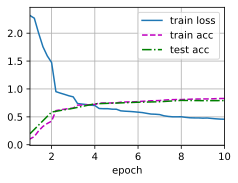

In [63]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())